In [1]:
#IMPORTAZIONE DELLE LIBRERIE
import pandas as pd #PER STRUTTURE DATI E MANIPOLAZIONE (DF/SERIES)
import seaborn as sns #PER PLOT
import matplotlib.pyplot as plt #PER PLOT


In [2]:
#CREAZIONE DEL DATASET E VISUALIZZAZIONE DI DIMENSIONI
#VISUALIZZAZIONI TIPI DI DATO DELLE COLONNE
df = pd.read_csv('insurance.csv')
df.head()
df.info()
# Alcune feature necessitano di essere manipolate prima di essere utilizzate
# Ad esempio la colonna id viene tolta in quanto irrilevante ai fini dell'analisi

df.describe()
# the average customers vintage (numbers of day been insured in the compant is 154 days)
# no customers in this data set have been with the insurance company for 1 full year
# the oldest customers in this dataset is 85 while the median is 36
# the most expensive annual premium is almost 17 times more expensive compared to the median annual premium
# this data definitely need a scalling to get a better result in the machine learning process

#Mostro i valori unici presenti in ogni colonna
df = df.drop(columns = 'id')

for column in df.columns:
    print(f"{column}: ")
    print("")
    print(df[column].unique())
    print("")

df.describe(include = 'O')
#La maggioranza sono di sesso maschile

(381109, 12)
id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object


In [3]:
#BOXPLOT DI AGE, ANNUAL_PREMIUM E VINTAGE
plt.subplot(1, 3, 1)
plt.boxplot(df[['Age']], flierprops={'marker': 'o', 'markersize': 2})
plt.subplot(1, 3, 2)
plt.boxplot(df[['Annual_Premium']], flierprops={'markersize': 2})
plt.subplot(1, 3, 3)
plt.boxplot(df[['Vintage']], flierprops={'markersize': 2})
plt.show()

#Si possono notare numerosi ouliers nella colonna di Annual_Premium


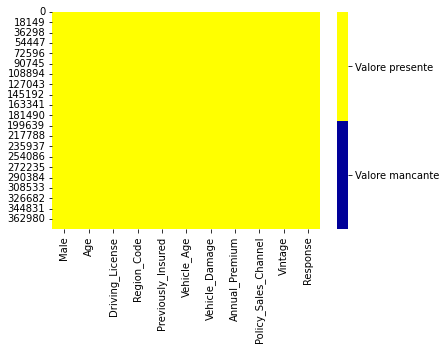

In [4]:
# PRE-PROCESSING
# CONVERSIONE DI "GENDER" IN BINARIO (MALE)
# CONVERSIONE DI VEHICLE_AGE IN NUMERICO E VEHICLE_DAMAGE IN BINARIO
df = df.rename(columns={"Gender": "Male"})
cleanup_nums = {"Vehicle_Age": {"< 1 Year": -1, "1-2 Year": 0, "> 2 Years": 1},
                "Vehicle_Damage": {"Yes": 1, "No": 0},
                "Male": {"Male": 1, "Female": 0}} #DIZIONARIO CONTENENTE
                                                  #REGOLE DI CONVERSIONE
df = df.replace(cleanup_nums)

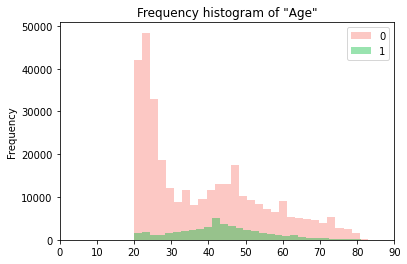

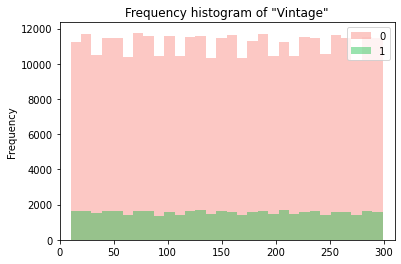

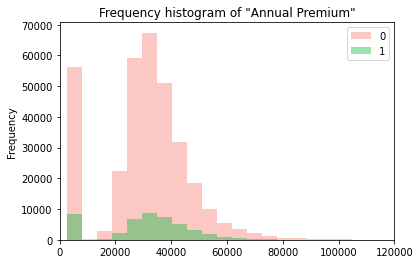

In [5]:
#MATRICE DI CORRELAZIONE
import numpy as np #PER TRIANGOLIZZAZIONE MATRICE DI CORRELAZIONE
corMatrix = df[['Age', 'Vehicle_Age', 'Annual_Premium', 'Vintage']].corr()
Matrix = np.triu(corMatrix)
sns.heatmap(corMatrix, annot=True, square=True, mask = Matrix)
plt.show()

#GRAFICO A TORTA CHE DIMOSTRA LO SBILANCIAMENTO
freq = df['Response'].value_counts(normalize=True) * 100
plt.pie(freq, autopct='%.0f%%')
plt.legend(['0', '1'])
plt.show()



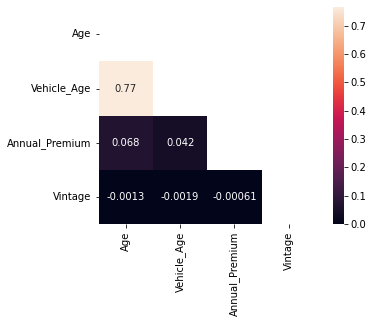

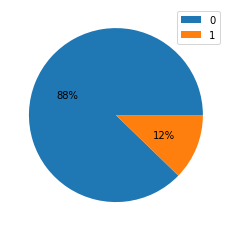

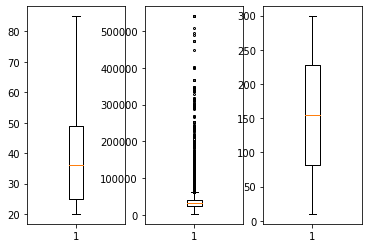

In [6]:
#SPLIT STRATIFICATO TEST/TRAIN
from sklearn import model_selection

y = df['Response']
x = df.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y,
                                                    stratify=y,
                                                    test_size=0.3,
                                                    random_state=1)

In [7]:
#FUNZIONE PER GENERAZIONE DI MATRICE DI CONFUSIONE E RESTITUZIONE DI PARAMETRI
#INTERESSANTI
def confusionMatrix (Prediction, Ground_Truth, verbose = False):
    from sklearn.metrics import confusion_matrix as cm
    CM = cm(Ground_Truth, Prediction)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    accuracy = (TP+TN)/(TP + FN + FP + TN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    if verbose:
        print("Accuracy:      %f\n" % accuracy)
        print("Sensitivity:   %f\n" % sensitivity)
        print("Specificity:   %f\n" % specificity)
    return accuracy, sensitivity, specificity

In [8]:
from sklearn.tree import DecisionTreeClassifier

#FUNZIONE PER LA CREAZIONE E IL TESTING DI ALBERI
def tree_test(X_train, y_train, X_test, y_test, verbose = True):
    dtree = DecisionTreeClassifier(random_state=1)
    dtree = dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    confusionMatrix(pred, y_test, verbose)
    return dtree

In [9]:
#FUNZIONE PER SALVATAGGIO DI 'fpr' E 'tpr' A PARTIRE DA MODELLO
def f_t_pr(model, X_test, y_test):
    from sklearn.metrics import roc_curve
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return fpr, tpr

In [11]:
#CREZIONE DI DATASET SENZA VARIABILI CATEGORICHE (PER ALBERO)
X_train_num = X_train.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
X_test_num = X_test.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1)
dtree = tree_test(X_train_num, y_train, X_test_num, y_test)

Accuracy:      0.823323

Sensitivity:   0.286377

Specificity:   0.898325



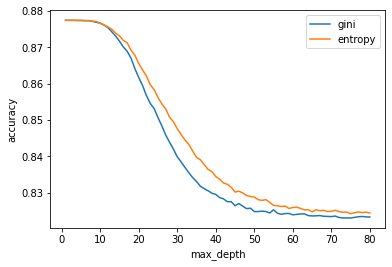

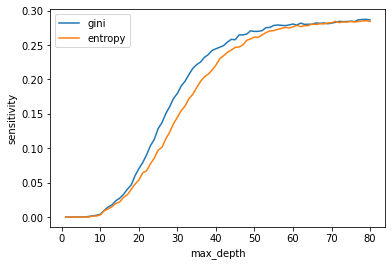

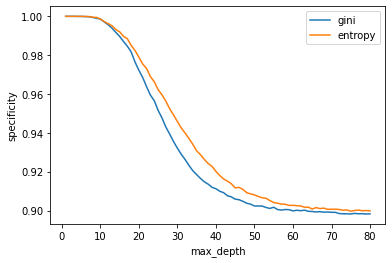

In [12]:
#VOGLIAMO VISUALIZZARE L'IMPATTO DELLA PROFONDITA' E DEL CRITERIO DI SPLIT
# SULLA QUALITA DELL'ALBERO (VERIFICARE RISCHIO OVERFITTING)
max = dtree.get_depth()
max_depth = []
acc_gini = []
acc_entropy = []
sens_gini = []
spec_gini = []
sens_entropy = []
spec_entropy = []
for i in range(1,max):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_gini.append(confusionMatrix(pred, y_test)[0])
 sens_gini.append(confusionMatrix(pred, y_test)[1])
 spec_gini.append(confusionMatrix(pred, y_test)[2])
 ####
 dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=1)
 dtree.fit(X_train_num, y_train)
 pred = dtree.predict(X_test_num)
 acc_entropy.append(confusionMatrix(pred, y_test)[0])
 sens_entropy.append(confusionMatrix(pred, y_test)[1])
 spec_entropy.append(confusionMatrix(pred, y_test)[2])
 ####
 max_depth.append(i)

d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                  'sens_gini': pd.Series(sens_gini),
                  'spec_gini': pd.Series(spec_gini),
                  'acc_entropy':pd.Series(acc_entropy),
                  'sens_entropy':pd.Series(sens_entropy),
                  'spec_entropy':pd.Series(spec_entropy),
                  'max_depth':pd.Series(max_depth)})

# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot('max_depth','sens_gini', data=d, label='gini')
plt.plot('max_depth','sens_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('sensitivity')
plt.legend()
plt.show()

plt.plot('max_depth','spec_gini', data=d, label='gini')
plt.plot('max_depth','spec_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('specificity')
plt.legend()
plt.show()

In [13]:
#RIBILANCIAMENTO CON UNDERSAMPLING CASUALE
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy={0:y_train.value_counts()[1], 1:(int(y_train.value_counts()[1]*0.7))})
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)
print(y_train_under.value_counts())

#RIBILANCIAMENTO CON SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
print(y_train_over.value_counts())

# SMOTE + RANDOM UNDERSAMPLING
#The original paper on SMOTE suggested combining SMOTE
# with random undersampling of the majority class.
oversample = SMOTE(sampling_strategy=0.3) #porto lo sbilanicamento al 30%
under = RandomUnderSampler(sampling_strategy=0.7)
X_train_mix, y_train_mix = oversample.fit_resample(X_train, y_train)
X_train_mix, y_train_mix = under.fit_resample(X_train_mix, y_train_mix)
print(y_train_mix.value_counts())


0    32697
1    22887
Name: Response, dtype: int64
1    234079
0    234079
Name: Response, dtype: int64
0    100318
1     70223
Name: Response, dtype: int64


In [15]:
#ALTRI ALBERI (CON DATASET VARI)

#ALBERO CON UNDERSAMPLING CASUALE
X_train_under_num = X_train_under.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_us = tree_test(X_train_under_num, y_train_under, X_test_num, y_test)

Accuracy:      0.735877

Sensitivity:   0.633340

Specificity:   0.750199

Accuracy:      0.735877

Sensitivity:   0.633340

Specificity:   0.750199



In [15]:
#ALBERO CON SMOTE
X_train_over_num = X_train_over.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_os = tree_test(X_train_over_num, y_train_over, X_test_num, y_test)

Accuracy:      0.766891

Sensitivity:   0.536002

Specificity:   0.799143



In [16]:
#ARBERO CON SMOTE + UNDERSAMPLING RANDOM
X_train_mix_num = X_train_mix.drop(['Region_Code','Policy_Sales_Channel'], axis=1)
dtree_mix = tree_test(X_train_mix_num, y_train_mix, X_test_num, y_test)

Accuracy:      0.757751

Sensitivity:   0.572254

Specificity:   0.783662



In [16]:
#FUNZIONE PER STAMPA DELLE CURVE ROC
def plot_roc(*args, X_test, y_test, labels=[]):
    i = 0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for model in args:
        fpr, tpr = f_t_pr(model, X_test, y_test)
        plt.plot(fpr, tpr, color=colors[i], label=labels[i])
        i+=1
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

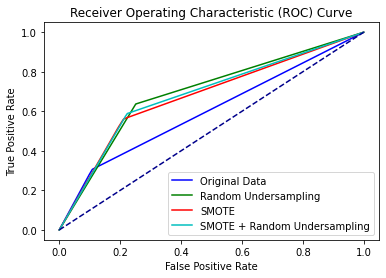

In [18]:
#STAMPA DELLE CURVE ROC
lab = ['Original Data', 'Random Undersampling', 'SMOTE', 'SMOTE + Random Undersampling']
plot_roc(dtree, dtree_us, dtree_os, dtree_mix, X_test = X_test_num, y_test = y_test, labels=lab)

In [19]:
#NAIVE BAYES SBILANCIATO
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.820323

Sensitivity:   0.363020

Specificity:   0.884201



(0.8203230913209659, 0.3630200528081068, 0.8842005582137161)

In [20]:
#NAIVE BAYES UNDERSAMPLING CASUALE
gnb = GaussianNB()
gnb_us = gnb.fit(X_train_under, y_train_under)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.700690

Sensitivity:   0.848997

Specificity:   0.679974



(0.7006900894754795, 0.848997359594662, 0.6799740829346093)

In [21]:
#NAIVE BAYES SMOTE

gnb = GaussianNB()
gnb_os = gnb.fit(X_train_over, y_train_over)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.691716

Sensitivity:   0.863555

Specificity:   0.667713



(0.6917163023798903, 0.8635552701063298, 0.66771331738437)

In [22]:
#NAIVE BAYES MIX

gnb = GaussianNB()
gnb_mix = gnb.fit(X_train_mix, y_train_mix)
pred = gnb.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.706436

Sensitivity:   0.838721

Specificity:   0.687959



(0.7064364619138831, 0.838721187468779, 0.6879585326953748)

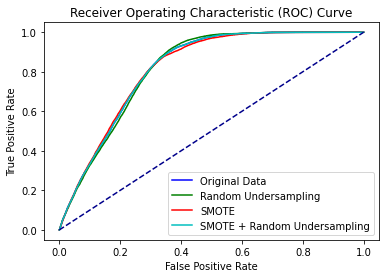

In [23]:
#STAMPA DELLE CURVE ROC
plot_roc(gnb, gnb_us, gnb_os, gnb_mix, X_test = X_test, y_test = y_test, labels=lab)

In [27]:
#SVM CON DATASET SBILANCIATO
from sklearn import svm

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.869180

Sensitivity:   0.039535

Specificity:   0.985068



(0.8691803766191738, 0.03953471776207807, 0.9850677830940989)

In [25]:
#SVM CON UNDERSAMPLING CASUALE

clf = svm.SVC(kernel='linear')
clf.fit(X_train_under, y_train_under)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.740958

Sensitivity:   0.773710

Specificity:   0.736384



(0.7409584284502287, 0.7737101263112823, 0.7363835725677831)

In [19]:
#SVM CON SMOTE
clf = svm.SVC(kernel='linear')
clf.fit(X_train_over, y_train_over)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.686652

Sensitivity:   0.858060

Specificity:   0.662709



(0.6866521476738999, 0.8580603725112396, 0.6627093301435407)

In [20]:
#SVM CON SMOTE + UNDERSAMPLING
clf = svm.SVC(kernel='linear')
clf.fit(X_train_mix, y_train_mix)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.737609

Sensitivity:   0.783986

Specificity:   0.731130



(0.7376085644564562, 0.7839862984371655, 0.7311303827751197)

In [22]:
#SVM CON COSTI
clf = svm.SVC(kernel='linear', class_weight= {0 : 1, 1 : 5})
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
confusionMatrix(pred, y_test, True)

Accuracy:      0.656984

Sensitivity:   0.933419

Specificity:   0.618371



(0.6569844226951099, 0.9334189681010491, 0.6183712121212122)

In [25]:
#XGBOOST su UNDERSAMPLED
from xgboost import XGBClassifier

XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True, eval_metric = 'logloss')
XGB = XGB.fit(X_train_under, y_train_under)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)

c:\users\placi\pycharmprojects\insurance\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:      0.735632

Sensitivity:   0.851852

Specificity:   0.719398



(0.7356318823086948, 0.8518518518518519, 0.7193979266347688)

In [26]:
XGB = XGBClassifier(tree_method= "gpu_hist", single_precision_histogram = True, scale_pos_weight=7, eval_metric = 'logloss')
XGB = XGB.fit(X_train, y_train)
pred = XGB.predict(X_test)
confusionMatrix(pred, y_test, verbose=True)

c:\users\placi\pycharmprojects\insurance\venv\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy:      0.712174

Sensitivity:   0.909156

Specificity:   0.684659



(0.7121740879711019, 0.9091557839149361, 0.6846590909090909)